## What is the cost of a reunion?
So you're having a reunion. Matty says: " Let's do it in Aachen.". Mike says: "Let's do it in Kaiserslautern.". There are several people coming... Where should they all meet?

This is a pretty common problem. You could be having a party, picking a location for a warehouse, building a new factory. In each case you will optimize the location based on several variables.

In this example, I've chosen travel time as my cost function.  
Google Maps has a nice API that returns a distance and time matrix. So we'll use that.

### Getting it to run

First import some libraries

In [1]:
import pandas as pd
import requests
import datetime

Now we need to establish the location of individuals who will be attending the fabulous event.

In [2]:
homelist = [
     ['Mike', 'Kaiserslautern, Germany'],
     ['Smash', 'Kaiserslautern, Germany'],
     ['Yawn', 'Kaiserslautern, Germany'],
     ['Therese', 'Kaiserslautern, Germany'],
     ['Dannyboy', 'Frankfurt, Germany'],
     ['Matador', 'Frankfurt, Germany'],
     ['Karabiner', 'Aachen, Germany'],
     ['Matty', 'Aachen, Germany'],
     ['Flow', 'Stuttgart, Germany']
        ]
homes = pd.DataFrame(homelist, columns=['person', 'home'])
homes

,person,home
0,Mike,"Kaiserslautern, Germany"
1,Smash,"Kaiserslautern, Germany"
2,Yawn,"Kaiserslautern, Germany"
3,Therese,"Kaiserslautern, Germany"
4,Dannyboy,"Frankfurt, Germany"
5,Matador,"Frankfurt, Germany"
6,Karabiner,"Aachen, Germany"
7,Matty,"Aachen, Germany"
8,Flow,"Stuttgart, Germany"


For the API, we need a set of destinations and a set of homes. In this case, we can celebrate at anyone's home so we will use the set of homes.

Using this information and a [Google Maps api key](https://developers.google.com/maps/documentation/distance-matrix/start), we can build our URL for the distance matrix API.

In [3]:
all_homes = homes.home.unique()
destinations = all_homes

A little trick for entering your API key without putting it in the notebook is using the `getpass` function.

In [4]:
from getpass import getpass
api_key = getpass()

········


And here we can take advantage of a new Python 3.6 feature, [Formatted string literals](https://docs.python.org/3/whatsnew/3.6.html#whatsnew36-pep498).

In [5]:
params = {
    'origins': f'{"|".join(destinations)}',
    'destinations': f'{"|".join(destinations)}',
    'mode': 'driving',
    'key': f'{api_key}',
}
url = f'https://maps.googleapis.com/maps/api/distancematrix/json'

Now we just need to fetch the URL.

In [6]:
r = requests.get(url, params=params)
content = r.json()
content

{'destination_addresses': ['Kaiserslautern, Germany',
  'Frankfurt, Germany',
  'Aachen, Germany',
  'Stuttgart, Germany'],
 'origin_addresses': ['Kaiserslautern, Germany',
  'Frankfurt, Germany',
  'Aachen, Germany',
  'Stuttgart, Germany'],
 'rows': [{'elements': [{'distance': {'text': '1 m', 'value': 0},
     'duration': {'text': '1 min', 'value': 0},
     'status': 'OK'},
    {'distance': {'text': '118 km', 'value': 118039},
     'duration': {'text': '1 hour 25 mins', 'value': 5123},
     'status': 'OK'},
    {'distance': {'text': '289 km', 'value': 289084},
     'duration': {'text': '2 hours 55 mins', 'value': 10477},
     'status': 'OK'},
    {'distance': {'text': '197 km', 'value': 197209},
     'duration': {'text': '2 hours 6 mins', 'value': 7531},
     'status': 'OK'}]},
  {'elements': [{'distance': {'text': '118 km', 'value': 117855},
     'duration': {'text': '1 hour 26 mins', 'value': 5180},
     'status': 'OK'},
    {'distance': {'text': '1 m', 'value': 0},
     'duration'

We want this as a list of lists so we can turn it into a data frame.

In [7]:
distance_matrix = [
    [datetime.timedelta(seconds=dest['duration']['value']) 
                    for dest in row['elements']] 
                   for row in content['rows']]

travel_times = pd.DataFrame(
    distance_matrix,
    columns=content['destination_addresses'],
    index=content['origin_addresses']
)

travel_times

,"Kaiserslautern, Germany","Frankfurt, Germany","Aachen, Germany","Stuttgart, Germany"
"Kaiserslautern, Germany",00:00:00,01:25:23,02:54:37,02:05:31
"Frankfurt, Germany",01:26:20,00:00:00,02:40:31,02:12:32
"Aachen, Germany",02:55:44,02:42:19,00:00:00,04:10:31
"Stuttgart, Germany",02:08:37,02:15:07,04:11:28,00:00:00


Now we have our distance matrix! Or, more correctly, our travel time matrix, which is a much better proxy for cost than distance.

Now all we need to do is write a function that will sum all of the individual travel times to create a 'total travel time' for a given destination.

In [8]:
def total_travel_time(destination):
    dest_times = travel_times[destination].sort_index()
    counts = homes.groupby('home').count().sort_index()
    counts.index.name = None
    person_times = dest_times * counts.person
    return person_times.sum()

Now we apply this function to the list of destinations and we have an array of costs for each destination.

In [9]:
tt_df = pd.DataFrame(
    list(map(total_travel_time, destinations)),
    index=destinations,
    columns=['total_time']
)

tt_df

,total_time
"Kaiserslautern, Germany",10:52:45
"Frankfurt, Germany",13:21:17
"Aachen, Germany",21:10:58
"Stuttgart, Germany",21:08:10


Now we create a bar graph because... bar graphs are an easy way to interpret this data.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

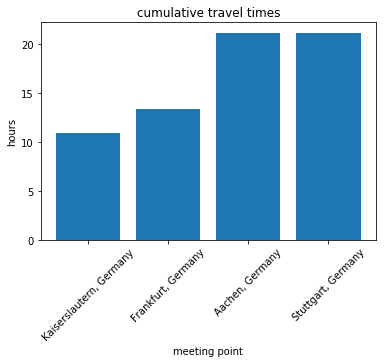

In [11]:
plt.bar(
    left=range(0, 4, 1),
    height=tt_df.total_time.apply(datetime.timedelta.total_seconds)/(60*60)
)
ticks = plt.xticks(range(0, 4, 1), tt_df.index, rotation=45)
max_time = max(tt_df.total_time.apply(datetime.timedelta.total_seconds)/(60*60))
plt.yticks(np.arange(0,max_time,5))
plt.ylabel('hours')
plt.xlabel('meeting point')
plt.title('cumulative travel times')

## Conclusion

We should meet in Kaiserslautern. But... What if everyone takes the train?

Since we're going to go through all this again, let's try to make it a convenient function.

In [12]:
from IPython.display import display

In [13]:
def travel_times(homes=None, 
                 destinations=None,
                 travel_mode='driving',
                 api_key=api_key):
    
    all_homes = homes.home.unique()
    
    params = {
        'origins': f'{"|".join(all_homes)}',
        'destinations': f'{"|".join(destinations)}',
        'mode': f'{travel_mode}',
        'key': f'{api_key}',
    }

    url = f'https://maps.googleapis.com/maps/api/distancematrix/json'
    
    r = requests.get(url, params=params)
    content = r.json()
    
    distance_matrix = [
        [datetime.timedelta(seconds=dest['duration']['value']) 
                        for dest in row['elements']] 
                       for row in content['rows']]

    print(f"Mapping found addresses:\n{content['origin_addresses']}\n\
    to given addresses:\n{homes.home.unique()}.")
    
    travel_times = pd.DataFrame(
        distance_matrix,
        columns=homes.home.unique(),
        index=destinations
    )
    
    display(travel_times)
    
    def total_travel_time(destination):
        dest_times = travel_times[destination].sort_index()
        counts = homes.groupby('home').count().sort_index()
        counts.index.name = None
        person_times = dest_times * counts.person
        return person_times.sum()
    
    total_travel_times = list(map(total_travel_time, destinations))

    tt_df = pd.DataFrame(
        list(map(total_travel_time, destinations)),
        index=destinations,
        columns=['total_time']
    )
    
    display(tt_df)
    
    plt.bar(
        left=range(0, 4, 1),
        height=tt_df.total_time.apply(datetime.timedelta.total_seconds)/(60*60)
    )
    ticks = plt.xticks(range(0, 4, 1), tt_df.index, rotation=45)
    max_time = max(tt_df.total_time.apply(datetime.timedelta.total_seconds)/(60*60))
    plt.yticks(np.arange(0,max_time,5))
    plt.ylabel('hours')
    plt.xlabel('meeting point')
    plt.title('cumulative travel times')

Now, we can try it out and check we got the same result...

Mapping found addresses:
['Kaiserslautern, Germany', 'Frankfurt, Germany', 'Aachen, Germany', 'Stuttgart, Germany']
    to given addresses:
['Kaiserslautern, Germany' 'Frankfurt, Germany' 'Aachen, Germany'
 'Stuttgart, Germany'].


,"Kaiserslautern, Germany","Frankfurt, Germany","Aachen, Germany","Stuttgart, Germany"
"Kaiserslautern, Germany",00:00:00,01:25:23,02:54:37,02:05:31
"Frankfurt, Germany",01:26:20,00:00:00,02:40:31,02:12:32
"Aachen, Germany",02:55:44,02:42:19,00:00:00,04:10:31
"Stuttgart, Germany",02:08:37,02:15:07,04:11:28,00:00:00


,total_time
"Kaiserslautern, Germany",10:52:45
"Frankfurt, Germany",13:21:17
"Aachen, Germany",21:10:58
"Stuttgart, Germany",21:08:10


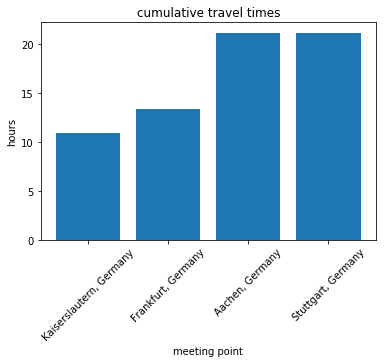

In [14]:
travel_times(homes=homes, destinations=homes.home.unique())

Looks good! Now let's try using public transport.

Mapping found addresses:
['Kaiserslautern, Germany', 'Frankfurt, Germany', 'Aachen, Germany', 'Stuttgart, Germany']
    to given addresses:
['Kaiserslautern, Germany' 'Frankfurt, Germany' 'Aachen, Germany'
 'Stuttgart, Germany'].


,"Kaiserslautern, Germany","Frankfurt, Germany","Aachen, Germany","Stuttgart, Germany"
"Kaiserslautern, Germany",00:00:00,01:23:00,03:37:00,01:47:00
"Frankfurt, Germany",01:23:00,00:00:00,02:20:00,01:27:00
"Aachen, Germany",03:37:00,02:24:00,00:00:00,03:26:00
"Stuttgart, Germany",01:38:00,01:25:00,03:24:00,00:00:00


,total_time
"Kaiserslautern, Germany",11:38:00
"Frankfurt, Germany",11:45:00
"Aachen, Germany",22:32:00
"Stuttgart, Germany",16:54:00


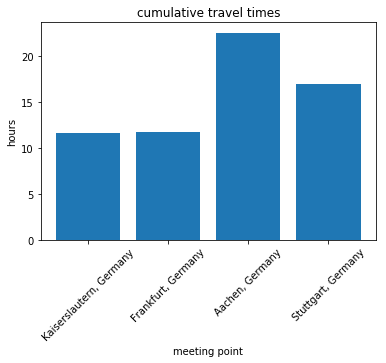

In [15]:
travel_times(homes=homes, destinations=homes.home.unique(), travel_mode='transit')

## Conclusion
We should meet in Frankfurt.

# London

So, I'm from London and we all used to meet up at Adam's house because his dad would help us set up networked Halo on Xbox. Let's see how sensible that was.

In [16]:
london_homes = [
     ['Bodger', 'Putney Bridge Station, London'],
     ['Cully', 'Dalston Kingsland, London'],
     ['Worth',  'North Harrow Station, London'],
     ['Captain Polski', 'Berrylands Station, London'],
        ]
london_homes = pd.DataFrame(london_homes, columns=['person', 'home'])
london_homes

,person,home
0,Bodger,"Putney Bridge Station, London"
1,Cully,"Dalston Kingsland, London"
2,Worth,"North Harrow Station, London"
3,Captain Polski,"Berrylands Station, London"


Mapping found addresses:
['Putney Bridge Underground Station, Fulham, London SW6 3UH, UK', 'London E8 2PA, UK', 'Station Rd, Harrow HA2 7SR, UK', 'Chiltern Dr, Surbiton, Kingston upon Thames KT5 8LS, UK']
    to given addresses:
['Putney Bridge Station, London' 'Dalston Kingsland, London'
 'North Harrow Station, London' 'Berrylands Station, London'].


,"Putney Bridge Station, London","Dalston Kingsland, London","North Harrow Station, London","Berrylands Station, London"
"Putney Bridge Station, London",00:00:00,00:49:28,00:57:44,00:34:43
"Dalston Kingsland, London",00:45:57,00:00:00,00:56:04,00:55:31
"North Harrow Station, London",00:45:15,00:36:41,00:00:00,01:10:13
"Berrylands Station, London",00:24:05,00:52:31,01:10:35,00:00:00


,total_time
"Putney Bridge Station, London",01:55:17
"Dalston Kingsland, London",02:18:40
"North Harrow Station, London",03:04:23
"Berrylands Station, London",02:40:27


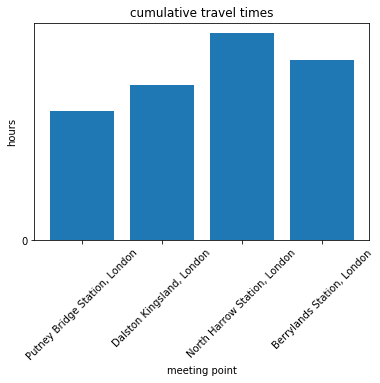

In [17]:
travel_times(homes=london_homes,
             destinations=london_homes.home.unique(), 
             travel_mode='transit')

### Retrospective

Adam seems sure we spent more time on my roof in Putney Bridge than we did at his house anyway. I guess we were smarter than I gave us credit for.